In [4]:
# This notebook analyzes the efficacy of different clustering algorithms for matching design patterns and design problems.
# Note: Table C2 in Hussain et al 2017 seems to indicate that fuzzy c-means clustering with binary weighting is the most effective combination for GoF patterns,
# but TF-IDF yields the highest f-value for fuzzy c-means (0.73).
# We are aiming for an f-value of 0.7 or above.

!pip install unidecode
!pip install fuzzy-c-means
!pip install --upgrade scikit-learn
!pip install scikit-learn-extra

from fcmeans                          import FCM

# Data Structures
import numpy  as np
import pandas as pd
import json
# Corpus Processing
import re
import nltk
import nltk.corpus
from nltk.tokenize                    import word_tokenize
from nltk.stem                        import WordNetLemmatizer
from nltk                             import SnowballStemmer, PorterStemmer
nltk.download('punkt')

from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing            import normalize, Normalizer
from sklearn.decomposition            import PCA, TruncatedSVD
from sklearn.cluster                  import KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn_extra.cluster            import KMedoids
from sklearn.pipeline                 import make_pipeline

from unidecode                        import unidecode

# K-Means
from sklearn                          import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud                        import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package punkt to /Users/remit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
np.random.seed(9)

import pandas as pd
#df_book = pd.read_csv("GoF problem domain (complete).csv")
df_book = pd.read_csv("GOF Patterns (2.0).csv")
#df_book['overview'] = df_book['intent'] + " " + df_book['motivation'] + " " + df_book['applicability']
df_book = df_book.drop_duplicates(subset=['name'])

#df_gof = pd.read_csv("scraped_pattern_data_gofpatterns_revised.csv")
df = df_book

In [6]:
# Add the design problem to the dataset.
# from the articles:
problemRow1 = {'name':"bridge design problem 1", 'correct_category':1, 'overview':"Design a system enabling to display on a screen some empty windows (no button, no menu…). A window can have several different styles depending on the platform used. We consider two platforms, XWindow and Presentation Manager. The client code must be written independently and without knowledge of the future execution platform. It is probable that the system evolves in order to display specialized windows by ‘application windows’ (able to manage applications) and ‘iconised windows’ (with an icon)"}
problemRow2 = {'name':"state design problem 2", 'correct_category':0,  'overview':"Design a DVD market place work. The DVD marketplace provides DVD to its clients with three categories: children, normal and new. A DVD is new during some weeks, and after change category. The DVD price depends on the category. It is probable that the system evolves in order to take into account the horror category"}
problemRow3 = {'name':"mediator design problem 3", 'correct_category':0,  'overview':"Design the communications of a plane approaching an airport. When a plane approaches an airport, it must announce to all the other planes which are around that it intends to land, and await their confirmation before carrying out the operation. It is the control tower of the airport which guarantees the regulation of the air traffic, by making sure that there is no trajectory or destination conflict between several planes. In addition to the class diagram, you must also submit a collaboration (in the form of a diagram of collaboration or a diagram of objects and sequence) that describes the landing of a plane amidst in a context of two demands to land and one wanting to take off"}
problemRow4 = {'name':"composite design problem 4", 'correct_category':1, 'overview':"Design a system enabling you to draw a graphic image. A graphic image is composed of lines, rectangles, texts, and images. An image may be composed of other images, lines, rectangles, and texts"}
problemRow5 = {'name':"decorator design problem 5", 'correct_category':1, 'overview':"Design a system enabling you to display visual objects on a screen. A visual object can be composed of one or more texts or images. If needed, the system must allow the addition of a vertical scroll bar, a horizontal scroll bar, an edge and a menu to this object. These additions may be accumulated."}
problemRow6 = {'name':"chain of responsbility design problem 6", 'correct_category':0, 'overview':"Design a help manager for a Java application. A help manager allows the display of a help message depending on the objects on which a client has clicked. For example, the “?”, sometimes located near the contextual menu of a Windows dialog box, allows the display of the help related to the button or the area where to click. If the button on which one clicks does not contain help, it is the area container which displays its help, and so on. If any object contains help, the help manager displays “No help available for this area”. Instantiate your class diagram in a sequence diagram of the example of a printing window. This window (JDialog) consists in an explanatory text (JLabel) and in a container (JPanel). This last contains a “Print button” (JButton) and a “Cancel button” (JButton). The “Print button” contains help “Launches the impression of the document”. The “Cancel button” the text as well as the window do not contain help. Lastly, the container contains help “Click on one of the buttons”. In the sequence diagram, reveal the scenarios: “The user asks for the help of the Print button”, “the user asks for the help of the Cancel button”, and “the user asks for the help of the text”"}
problemRow7 = {'name':"command design problem 7", 'correct_category':0, 'overview':"Design a tutorial to learn how to program a calculator. This calculator executes the four basic arithmetic operations. The goal of this tutorial is to make it possible to take a set of operations to be executed sequentially. The tutorial presents a button for each arithmetic operation, and two input fields for the operands. After each click on a button of an operation, the user has then the choice to start again or execute the sequence of operations to obtain the result. It is probable that this tutorial evolves in order to make it possible for the user to remove the last operation of the list and to take into account the operation of modulo"}
problemRow8 = {'name':"visitor design problem 8", 'correct_category':0, 'overview':"Many distinct and unrelated operations need to be performed on node objects in a heterogeneous aggregate structure. You want to avoid ‘polluting’ the node classes with these operations. And, you don't want to have to query the type of each node and cast the pointer to the correct type before performing the desired operation."}
problemRow9 = {'name':"adapter design problem 9", 'correct_category':1, 'overview':"Design a drawing editor. A design is composed of te graphics (lines, rectangles and roses), positioned at precise positions. Each graphic form must be modeled by a class that provides a method draw(): void. A rose is a complex graphic designed by a black-box class component. This component performs this drawing in memory, and provides access through a method getRose(): int that returns the address of the drawing. It is probable that the system evolves in order to draw circles"}

# from Source Making:
problemRow10 = {'name':"abstract factory source making", 'correct_category':2, 'overview':"If an application is to be portable, it needs to encapsulate platform dependencies. These platforms might include: windowing system, operating system, database, etc. Too often, this encapsulation is not engineered in advance, and lots of #ifdef case statements with options for all currently supported platforms begin to procreate like rabbits throughout the code."}
problemRow11 = {'name':"builder source making", 'correct_category':2, 'overview':"An application needs to create the elements of a complex aggregate. The specification for the aggregate exists on secondary storage and one of many representations needs to be built in primary storage."}
problemRow12 = {'name':"factory method source making", 'correct_category':2, 'overview':"A framework needs to standardize the architectural model for a range of applications, but allow for individual applications to define their own domain objects and provide for their instantiation."}
problemRow13 = {'name':"object pool source making", 'correct_category':2, 'overview':"Object pools (otherwise known as resource pools) are used to manage the object caching. A client with access to a Object pool can avoid creating a new Objects by simply asking the pool for one that has already been instantiated instead. Generally the pool will be a growing pool, i.e. the pool itself will create new objects if the pool is empty, or we can have a pool, which restricts the number of objects created. It is desirable to keep all Reusable objects that are not currently in use in the same object pool so that they can be managed by one coherent policy. To achieve this, the Reusable Pool class is designed to be a singleton class."}
problemRow14 = {'name':"prototype source making", 'correct_category':2, 'overview':"Application hard wires the class of object to create in each new expression."}
problemRow15 = {'name':"singleton source making", 'correct_category':2, 'overview':"Application needs one, and only one, instance of an object. Additionally, lazy initialization and global access are necessary."}
problemRow16 = {'name':"adapter source making", 'correct_category':1, 'overview':"An off the shelf component offers compelling functionality that you would like to reuse, but its view of the world is not compatible with the philosophy and architecture of the system currently being developed."}
problemRow17 = {'name':"bridge source making", 'correct_category':1, 'overview':"Hardening of the software arteries has occurred by using subclassing of an abstract base class to provide alternative implementations. This locks in compile-time binding between interface and implementation. The abstraction and implementation cannot be independently extended or composed."}
problemRow18 = {'name':"composite source making", 'correct_category':1, 'overview':"Application needs to manipulate a hierarchical collection of primitive and composite objects. Processing of a primitive object is handled one way, and processing of a composite object is handled differently. Having to query the type of each object before attempting to process it is not desirable."}
problemRow19 = {'name':"decorator source making", 'correct_category':1, 'overview':"You want to add behavior or state to individual objects at run-time. Inheritance is not feasible because it is static and applies to an entire class."}
problemRow20 = {'name':"facade source making", 'correct_category':1, 'overview':"A segment of the client community needs a simplified interface to the overall functionality of a complex subsystem."}
problemRow21 = {'name':"flyweight source making", 'correct_category':1, 'overview':"Designing objects down to the lowest levels of system granularity provides optimal flexibility, but can be unacceptably expensive in terms of performance and memory usage."}
problemRow22 = {'name':"private class data source making", 'correct_category':1, 'overview':"A class may expose its attributes (class variables) to manipulation when manipulation is no longer desirable, e.g. after construction. Using the private class data design pattern prevents that undesirable manipulation. A class may have one-time mutable attributes that cannot be declared final. Using this design pattern allows one-time setting of those class attributes. The motivation for this design pattern comes from the design goal of protecting class state by minimizing the visibility of its attributes (data)."}
problemRow23 = {'name':"proxy source making", 'correct_category':1, 'overview':"You need to support resource-hungry objects, and you do not want to instantiate such objects unless and until they are actually requested by the client."}
problemRow24 = {'name':"chain of responsibility source making", 'correct_category':0, 'overview':"There is a potentially variable number of handler or processing element or node objects, and a stream of requests that must be handled. Need to efficiently process the requests without hard-wiring handler relationships and precedence, or request-to-handler mappings."}
problemRow25 = {'name':"command source making", 'correct_category':0, 'overview':"Need to issue requests to objects without knowing anything about the operation being requested or the receiver of the request."}
problemRow26 = {'name':"interpreter source making", 'correct_category':0, 'overview':"A class of problems occurs repeatedly in a well-defined and well-understood domain. If the domain were characterized with a language, then problems could be easily solved with an interpretation engine."}
problemRow27 = {'name':"iterator source making", 'correct_category':0, 'overview':"Need to abstract the traversal of wildly different data structures so that algorithms can be defined that are capable of interfacing with each transparently."}
problemRow28 = {'name':"mediator source making", 'correct_category':0, 'overview':"We want to design reusable components, but dependencies between the potentially reusable pieces demonstrates the spaghetti code phenomenon (trying to scoop a single serving results in an all or nothing clump)."}
problemRow29 = {'name':"memento source making", 'correct_category':0, 'overview':"Need to restore an object back to its previous state (e.g. undo or rollback operations)."}
problemRow30 = {'name':"null object source making", 'correct_category':0, 'overview':"Given that an object reference may be optionally null, and that the result of a null check is to do nothing or use some default value, how can the absence of an object — the presence of a null reference — be treated transparently?"}
problemRow31 = {'name':"observer source making", 'correct_category':0, 'overview':"A large monolithic design does not scale well as new graphing or monitoring requirements are levied."}
problemRow32 = {'name':"state source making", 'correct_category':0, 'overview':"A monolithic object's behavior is a function of its state, and it must change its behavior at run-time depending on that state. Or, an application is characterized by large and numerous case statements that vector flow of control based on the state of the application."}
problemRow33 = {'name':"strategy source making", 'correct_category':0, 'overview':"One of the dominant strategies of object-oriented design is the open-closed principle. Figure demonstrates how this is routinely achieved - encapsulate interface details in a base class, and bury implementation details in derived classes. Clients can then couple themselves to an interface, and not have to experience the upheaval associated with change: no impact when the number of derived classes changes, and no impact when the implementation of a derived class changes. A generic value of the software community for years has been, maximize cohesion and minimize coupling. The object-oriented design approach shown in figure is all about minimizing coupling. Since the client is coupled only to an abstraction (i.e. a useful fiction), and not a particular realization of that abstraction, the client could be said to be practicing abstract coupling . an object-oriented variant of the more generic exhortation minimize coupling. A more popular characterization of this abstract coupling principle is Program to an interface, not an implementation. Clients should prefer the additional level of indirection that an interface (or an abstract base class) affords. The interface captures the abstraction (i.e. the useful fiction) the client wants to exercise, and the implementations of that interface are effectively hidden."}
problemRow34 = {'name':"template method source making", 'correct_category':0, 'overview':"Two different components have significant similarities, but demonstrate no reuse of common interface or implementation. If a change common to both components becomes necessary, duplicate effort must be expended."}
problemRow35 = {'name':"visitor source making", 'correct_category':0, 'overview':"Many distinct and unrelated operations need to be performed on node objects in a heterogeneous aggregate structure. You want to avoid polluting the node classes with these operations. And, you don't want to have to query the type of each node and cast the pointer to the correct type before performing the desired operation."}

# from Refactoring Guru:
problemRow36 = {'name':"factory method guru", 'correct_category':2, 'overview':""}
problemRow37 = {'name':"abstract factory guru", 'correct_category':2, 'overview':""}
problemRow38 = {'name':"builder guru", 'correct_category':2, 'overview':""}
problemRow39 = {'name':"prototype guru", 'correct_category':2, 'overview':""}
problemRow40 = {'name':"singleton guru", 'correct_category':2, 'overview':""}
problemRow41 = {'name':"adapter guru", 'correct_category':1, 'overview':""}
problemRow42 = {'name':"bridge guru", 'correct_category':1, 'overview':""}
problemRow43 = {'name':"composite guru", 'correct_category':1, 'overview':""}
problemRow44 = {'name':"decorator guru", 'correct_category':1, 'overview':""}
problemRow45 = {'name':"facade guru", 'correct_category':1, 'overview':""}
problemRow46 = {'name':"flyweight guru", 'correct_category':1, 'overview':""}
problemRow47 = {'name':"proxy guru", 'correct_category':1, 'overview':""}
problemRow48 = {'name':"chain of responsibility guru", 'correct_category':0, 'overview':""}
problemRow49 = {'name':"command guru", 'correct_category':0, 'overview':""}
problemRow50 = {'name':"iterator guru", 'correct_category':0, 'overview':""}
problemRow51 = {'name':"mediator guru", 'correct_category':0, 'overview':""}
problemRow52 = {'name':"memento guru", 'correct_category':0, 'overview':""}
problemRow53 = {'name':"observer guru", 'correct_category':0, 'overview':""}
problemRow54 = {'name':"state guru", 'correct_category':0, 'overview':""}
problemRow55 = {'name':"strategy guru", 'correct_category':0, 'overview':""}
problemRow56 = {'name':"template method guru", 'correct_category':0, 'overview':""}
problemRow57 = {'name':"visitor guru", 'correct_category':0, 'overview':""}

# from Wikipedia articles on design patterns:
problemRow58 = {'name':"abstract factory wiki", "correct_category":2, 'overview':"How can an application be independent of how its objects are created? How can a class be independent of how the objects that it requires are created? How can families of related or dependent objects be created? Creating objects directly within the class that requires the objects is inflexible because doing so commits the class to particular objects and makes it impossible to change the instantiation later independently from the class without having to change it. It prevents the class from being reusable if other objects are required, and it makes the class difficult to test because real objects cannot be replaced with mock objects. A factory is the location of a concrete class in the code at which objects are constructed. Implementation of the pattern intends to insulate the creation of objects from their usage and to create families of related objects without having to depend on their concrete classes.[2] This allows for new derived types to be introduced with no change to the code that uses the base class."}
problemRow59 = {'name':"builder wiki", "correct_category":2, 'overview':"How can a class (the same construction process) create different representations of a complex object? How can a class that includes creating a complex object be simplified? Creating and assembling the parts of a complex object directly within a class is inflexible. It commits the class to creating a particular representation of the complex object and makes it impossible to change the representation later independently from (without having to change) the class."}
problemRow60 = {'name':"factory wiki", "correct_category":2, 'overview':"How can an object be created so that subclasses can redefine which class to instantiate? How can a class defer instantiation to subclasses?"}
problemRow61 = {'name':"prototype wiki", "correct_category":2, 'overview':"How can objects be created so that which objects to create can be specified at run-time? How can dynamically loaded classes be instantiated? Creating objects directly within the class that requires (uses) the objects is inflexible because it commits the class to particular objects at compile-time and makes it impossible to specify which objects to create at run-time."}
problemRow62 = {'name':"singleton wiki", "correct_category":2, 'overview':"Ensure objects only have one instance Provide easy access to that instance Control their instantiation (for example, hiding the constructors of a class)"}
problemRow63 = {'name':"adapter wiki", "correct_category":1, 'overview':"How can a class be reused that does not have an interface that a client requires? How can classes that have incompatible interfaces work together? How can an alternative interface be provided for a class? Often an (already existing) class can't be reused only because its interface doesn't conform to the interface clients require."}
problemRow64 = {'name':"bridge wiki", "correct_category":1, 'overview':"An abstraction and its implementation should be defined and extended independently from each other. A compile-time binding between an abstraction and its implementation should be avoided so that an implementation can be selected at run-time. When using subclassing, different subclasses implement an abstract class in different ways. But an implementation is bound to the abstraction at compile-time and cannot be changed at run-time."}
problemRow65 = {'name':"composite wiki", "correct_category":1, 'overview':"A part-whole hierarchy should be represented so that clients can treat part and whole objects uniformly. A part-whole hierarchy should be represented as tree structure. When defining (1) Part objects and (2) Whole objects that act as containers for Part objects, clients must treat them separately, which complicates client code."}
problemRow66 = {'name':"decorator wiki", "correct_category":1, 'overview':"Responsibilities should be added to (and removed from) an object dynamically at run-time. A flexible alternative to subclassing for extending functionality should be provided. When using subclassing, different subclasses extend a class in different ways. But an extension is bound to the class at compile-time and can't be changed at run-time."}
problemRow67 = {'name':"facade wiki", "correct_category":1, 'overview':"To make a complex subsystem easier to use, a simple interface should be provided for a set of interfaces in the subsystem. The dependencies on a subsystem should be minimized. Clients that access a complex subsystem directly refer to (depend on) many different objects having different interfaces (tight coupling), which makes the clients hard to implement, change, test, and reuse."}
problemRow68 = {'name':"flyweight wiki", "correct_category":1, 'overview':"large numbers of objects with simple repeated elements that would use a large amount of memory if individually stored."}
problemRow69 = {'name':"proxy wiki", "correct_category":1, 'overview':"The access to an object should be controlled. Additional functionality should be provided when accessing an object. When accessing sensitive objects, for example, it should be possible to check that clients have the needed access rights."}
problemRow70 = {'name':"chain of responsibility wiki", "correct_category":2, 'overview':"Coupling the sender of a request to its receiver should be avoided. It should be possible that more than one receiver can handle a request. Implementing a request directly within the class that sends the request is inflexible because it couples the class to a particular receiver and makes it impossible to support multiple receivers."}
problemRow71 = {'name':"command wiki", "correct_category":2, 'overview':"Coupling the invoker of a request to a particular request should be avoided. That is, hard-wired requests should be avoided. It should be possible to configure an object (that invokes a request) with a request. Implementing (hard-wiring) a request directly into a class is inflexible because it couples the class to a particular request at compile-time, which makes it impossible to specify a request at run-time."}
problemRow72 = {'name':"interpreter wiki", "correct_category":2, 'overview':"A grammar for a simple language should be defined so that sentences in the language can be interpreted. When a problem occurs very often, it could be considered to represent it as a sentence in a simple language (Domain Specific Languages) so that an interpreter can solve the problem by interpreting the sentence. For example, when many different or complex search expressions must be specified. Implementing (hard-wiring) them directly into a class is inflexible because it commits the class to particular expressions and makes it impossible to specify new expressions or change existing ones independently from (without having to change) the class."}
problemRow73 = {'name':"iterator wiki", "correct_category":2, 'overview':"The elements of an aggregate object should be accessed and traversed without exposing its representation (data structures). New traversal operations should be defined for an aggregate object without changing its interface. Defining access and traversal operations in the aggregate interface is inflexible because it commits the aggregate to particular access and traversal operations and makes it impossible to add new operations later without having to change the aggregate interface."}
problemRow74 = {'name':"mediator wiki", "correct_category":2, 'overview':"Tight coupling between a set of interacting objects should be avoided. It should be possible to change the interaction between a set of objects independently. Defining a set of interacting objects by accessing and updating each other directly is inflexible because it tightly couples the objects to each other and makes it impossible to change the interaction independently from (without having to change) the objects. And it stops the objects from being reusable and makes them hard to test. Tightly coupled objects are hard to implement, change, test, and reuse because they refer to and know about many different objects."}
problemRow75 = {'name':"memento wiki", "correct_category":2, 'overview':"The internal state of an object should be saved externally so that the object can be restored to this state later. The object's encapsulation must not be violated. The problem is that a well designed object is encapsulated so that its representation (data structure) is hidden inside the object and can't be accessed from outside the object."}
problemRow76 = {'name':"observer wiki", "correct_category":2, 'overview':"A one-to-many dependency between objects should be defined without making the objects tightly coupled. When one object changes state, an open-ended number of dependent objects should be updated automatically. An object can notify multiple other objects. Defining a one-to-many dependency between objects by defining one object (subject) that updates the state of dependent objects directly is inflexible because it couples the subject to particular dependent objects. However, it might be applicable from a performance point of view or if the object implementation is tightly coupled (such as low-level kernel structures that execute thousands of times per second). Tightly coupled objects can be difficult to implement in some scenarios and are not easily reused because they refer to and are aware of many objects with different interfaces. In other scenarios, tightly coupled objects can be a better option because the compiler is able to detect errors at compile time and optimize the code at the CPU instruction level."}
problemRow77 = {'name':"state wiki", "correct_category":2, 'overview':"An object should change its behavior when its internal state changes. State-specific behavior should be defined independently. That is, adding new states should not affect the behavior of existing states. Implementing state-specific behavior directly within a class is inflexible because it commits the class to a particular behavior and makes it impossible to add a new state or change the behavior of an existing state later, independently from the class, without changing the class."}
problemRow78 = {'name':"strategy wiki", "correct_category":2, 'overview':"As an example, consider a car class. Two possible functionalities for car are brake and accelerate. Since accelerate and brake behaviors change frequently between models, a common approach is to implement these behaviors in subclasses. This approach has significant drawbacks: accelerate and brake behaviors must be declared in each new Car model. The work of managing these behaviors increases greatly as the number of models increases, and requires code to be duplicated across models. Additionally, it is not easy to determine the exact nature of the behavior for each model without investigating the code in each."}
problemRow79 = {'name':"template method wiki", "correct_category":2, 'overview':"The challenge of working with generated code is that changes to the source code will lead to changes in the generated code; if hand-written modifications have been made to the generated code, these will be lost. How, then, should the generated code be customized?"}
problemRow80 = {'name':"visitor wiki", "correct_category":2, 'overview':"It should be possible to define a new operation for (some) classes of an object structure without changing the classes. When new operations are needed frequently and the object structure consists of many unrelated classes, it's inflexible to add new subclasses each time a new operation is required because [..] distributing all these operations across the various node classes leads to a system that's hard to understand, maintain, and change."}

# Only append 1 design problem per experiment for better clustering results.
# We don't want a cluster that is mostly design problems written in similar wording.
df = df.append(problemRow76, ignore_index=True)

# try removing object words from design problem such as DVD, PLANE, etc...


/var/folders/w1/xcvx_nwj5m59ncgg9t053njm0000gn/T/ipykernel_881/2955495589.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(problemRow76, ignore_index=True)


In [7]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [8]:
nltk.download('stopwords')
def processCorpus(corpus, language, stemmer):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = stemmer
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = str(corpus[index]).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

[nltk_data] Downloading package stopwords to /Users/remit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
corpus = df['overview'].tolist()
corpus[18][0:447]

'Define a one-to-many dependency between objects so that when one object changes state, all its dependents are notified and updated automatically. A common side-effect of partitioning a system into a collection of cooperating classes is the need to maintain consistency between related objects. You don’t want to achieve consistency by making the classes tightly coupled, because that reduces their reusability.\n\nFor example, many graphical user in'

In [10]:
language = 'english'
stemmer = PorterStemmer()
corpus = processCorpus(corpus, language, stemmer)
corpus[18][0:460]

'defin one-to-mani depend object one object chang state depend notifi updat automat common side-effect partit system collect cooper class need maintain consist relat object want achiev consist make class tightli coupl reduc reusabl exampl mani graphic user interfac toolkit separ present aspect user interfac underli applic data class defin applic data present reus independ work togeth spreadsheet object bar chart object depict inform applic data object use d'

In [11]:
def vectorize_with_lsa(X_tfidf, n_comp):
  lsa = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
  X_lsa = lsa.fit_transform(X_tfidf)
  explained_variance = lsa[0].explained_variance_ratio_.sum()

  print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

  return X_lsa

In [12]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

24 rows


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
feel,0.287903,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
look,0.254794,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077744,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
widget,0.230008,0.061623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.147807,0.0,0.0,0.0,0.0,0.0,0.0,0.0
and,0.227478,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
motif,0.227478,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# from google.colab import files
# final_df.to_csv('GOF Patterns (2.0) tfidf sublinear.csv', encoding = 'utf-8-sig') 
# files.download('GOF Patterns (2.0) tfidf sublinear.csv')

In [14]:
# kmeans = KMeans(
#     n_clusters=3
# )

# kmeans.fit_predict(tf_idf)

In [15]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)
inertias = []

In [16]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k)
        kmeans_results.update( {k : kmeans.fit(data)} )
        inertias.append((kmeans_results.get(k)).inertia_)
        
    return kmeans_results

In [17]:
# fix the seed so that we get the same result across runs
np.random.seed(2023)

# Running Kmeans
inertias.clear()
k = 9
kmeans_results = run_KMeans(k, final_df)


/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/r

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


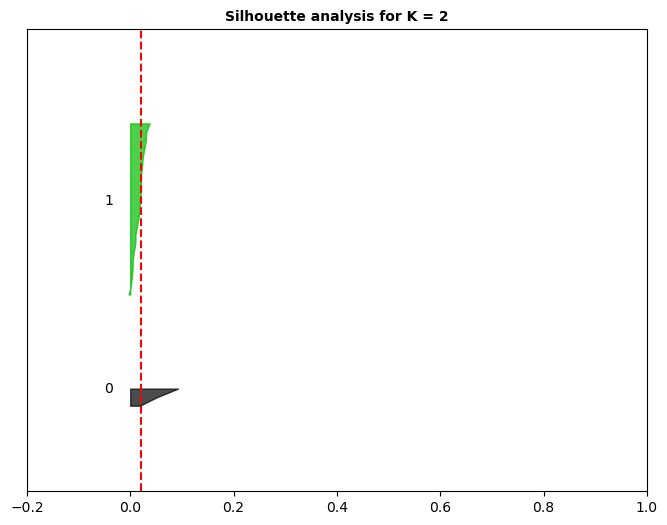

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


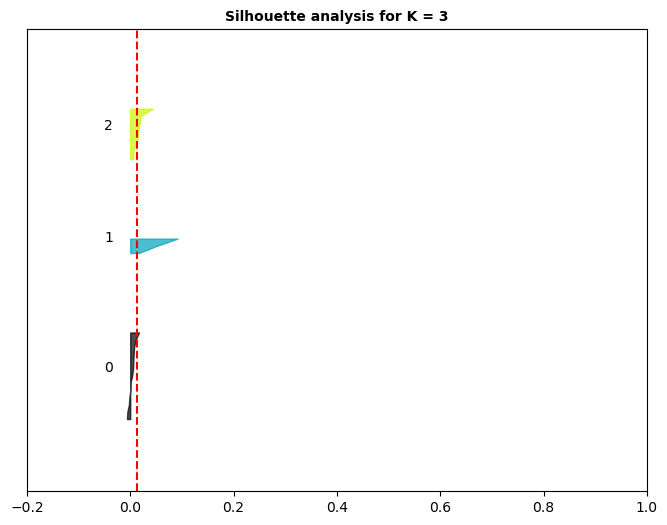

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


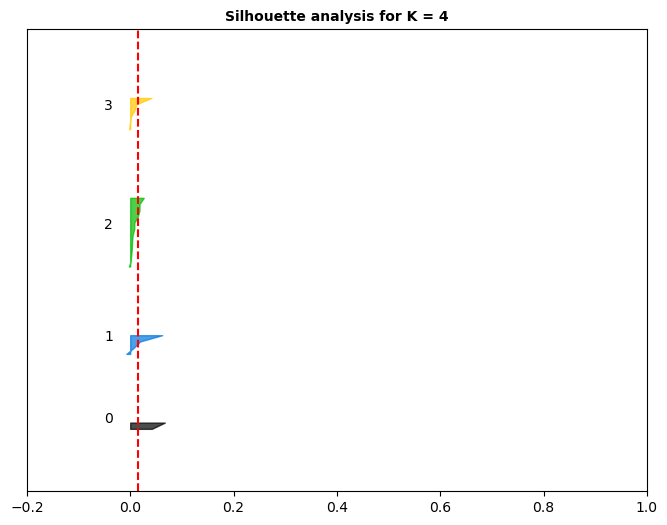

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


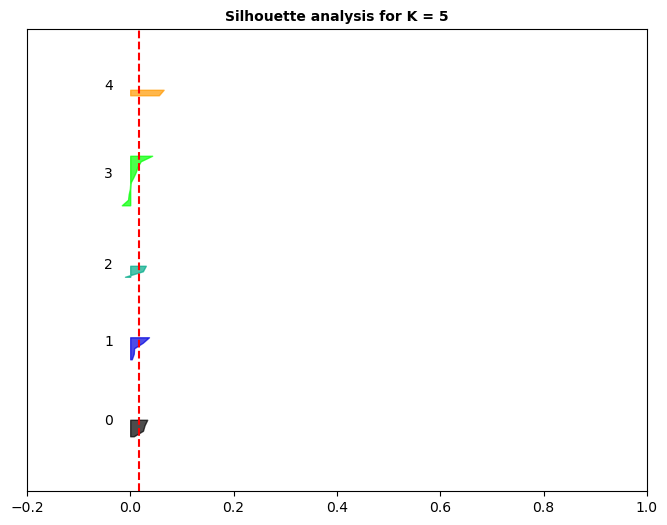

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


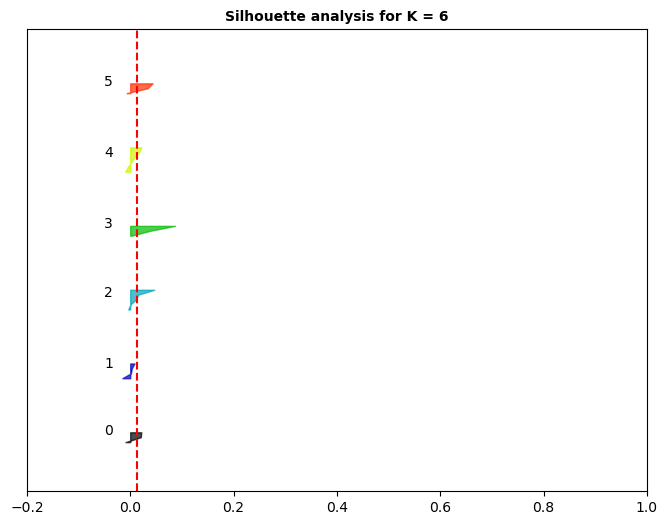

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


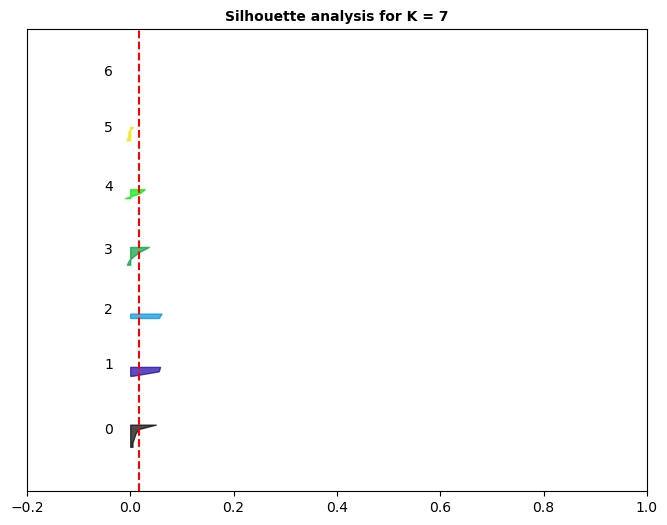

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


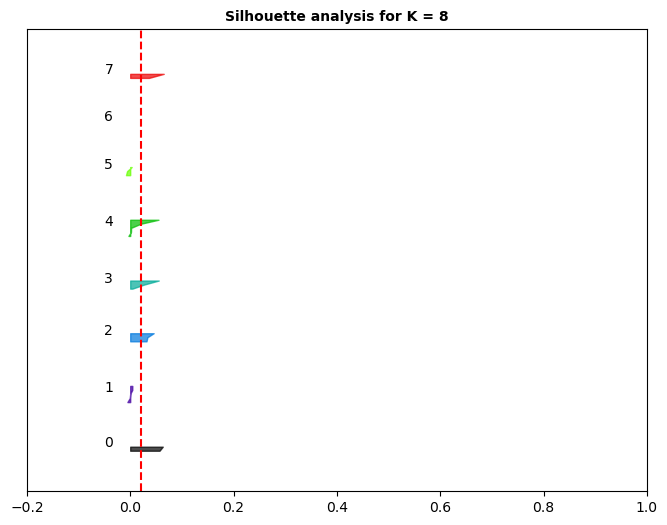

/Users/remit/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


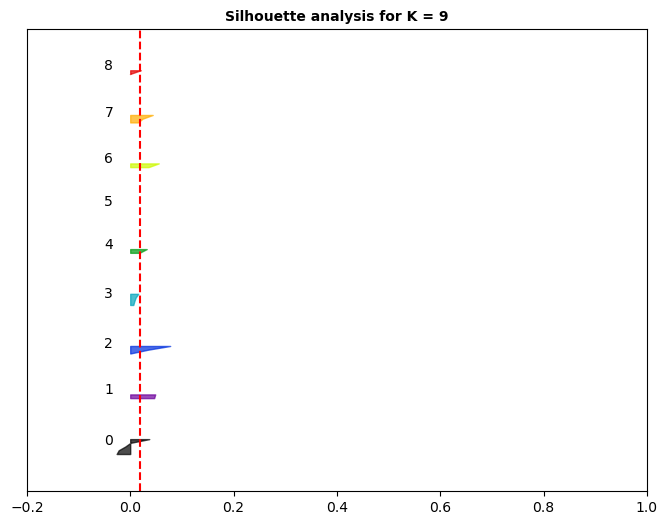

In [18]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()

def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

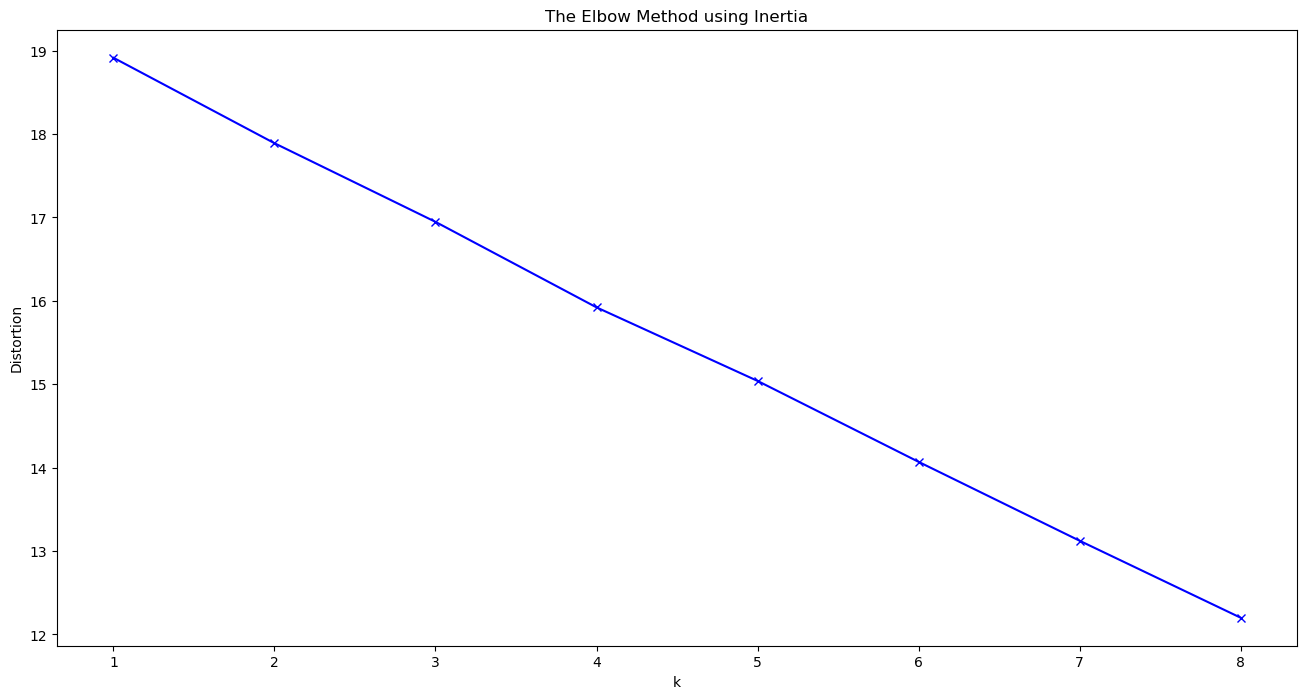

In [19]:
K = range(1, k)
plt.figure(figsize=(16,8))

# Elbow Method using inertia
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Inertia')
plt.show()

In [20]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

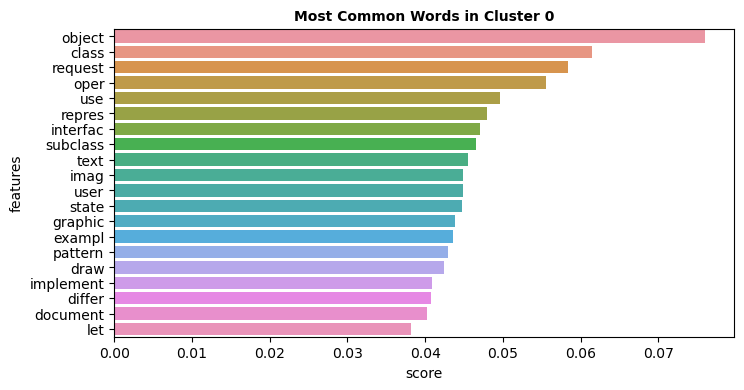

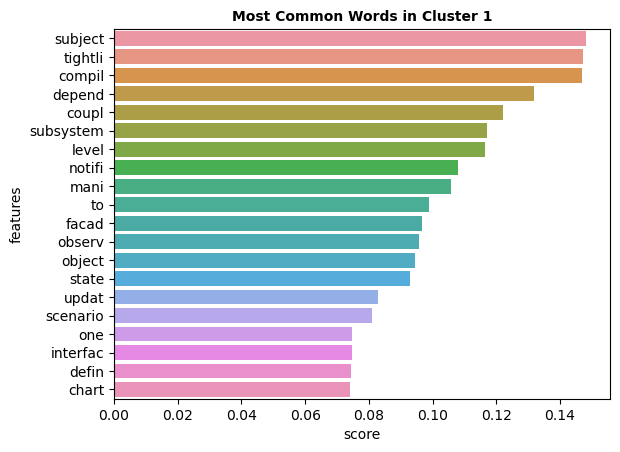

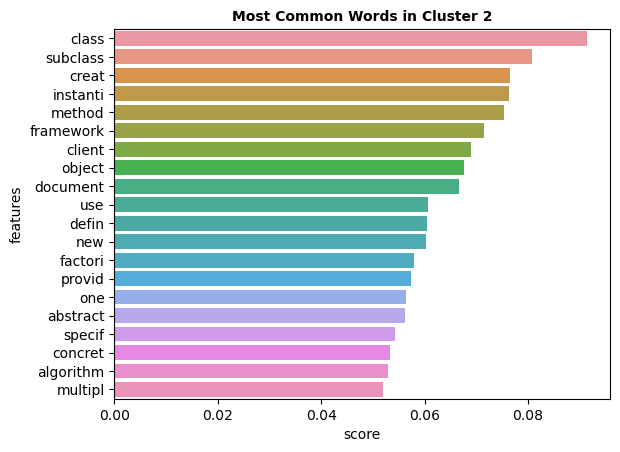

In [21]:
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 20)

In [22]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

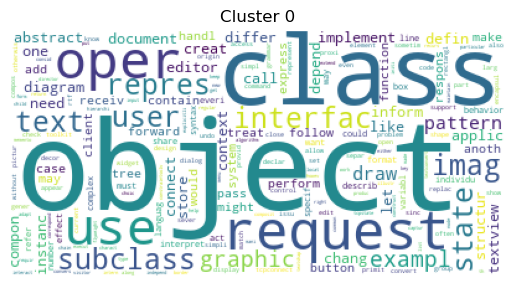

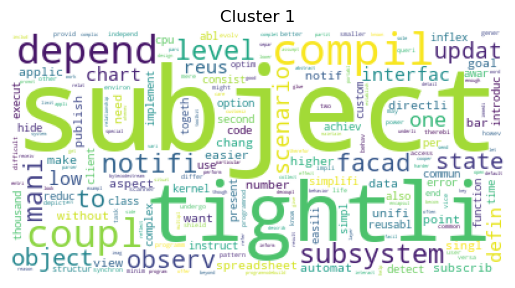

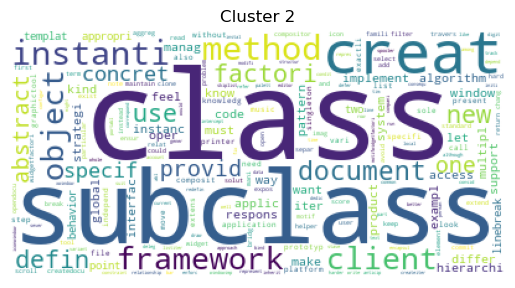

In [23]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [24]:
# Assigning the cluster labels to each pattern
Kmeans_labels = kmeans.labels_ 
df['Kmeans'] = Kmeans_labels

In [25]:
print("Cluster centroids: \n")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
tempk = 3
for i in range(tempk):
  print("Cluster %d:" % i)
  for j in order_centroids[i, :20]: #print out 10 features terms of each cluster
    print('%s'% terms[j])
  print('------------------')

Cluster centroids: 

Cluster 0:
object
class
request
oper
use
repres
interfac
subclass
text
imag
user
state
graphic
exampl
pattern
draw
implement
differ
document
let
------------------
Cluster 1:
subject
tightli
compil
depend
coupl
subsystem
level
notifi
mani
to
facad
observ
object
state
updat
scenario
one
interfac
defin
chart
------------------
Cluster 2:
class
subclass
creat
instanti
method
framework
client
object
document
use
defin
new
factori
provid
one
abstract
specif
concret
algorithm
multipl
------------------


In [26]:
# bisecting_strategy{“biggest_inertia”, “largest_cluster”}, default=”biggest_inertia”
Bi_Bisect = BisectingKMeans(n_clusters=3, bisecting_strategy="biggest_inertia")
Lc_Bisect = BisectingKMeans(n_clusters=3, bisecting_strategy="largest_cluster")
Hierarchy = AgglomerativeClustering(n_clusters=3)
Fuzzy_Means = FCM(n_clusters=3)
Fuzzy_Means.fit(final_df_array)
kmed = KMedoids(n_clusters=3)
kmed_manhattan = KMedoids(n_clusters=3,metric='manhattan')

fuzzy_labels = Fuzzy_Means.predict(final_df_array)
bi_bisect_labels = Bi_Bisect.fit_predict(final_df)
lc_bisect_labels = Lc_Bisect.fit_predict(final_df)  
hierarchy_labels = Hierarchy.fit_predict(final_df)
kmed_labels = kmed.fit_predict(final_df)
kmed_man_labels = kmed_manhattan.fit_predict(final_df)

df['fuzzy'] = fuzzy_labels
df['hierarchy'] = hierarchy_labels
df['Bi_Bisect'] = bi_bisect_labels  
df['Lc_Bisect'] = lc_bisect_labels
df['PAM-EUCLIDEAN'] = kmed_labels
df['PAM-MANHATTAN'] = kmed_man_labels


In [27]:
df

,Unnamed: 0,name,correct_category,overview,Kmeans,fuzzy,hierarchy,Bi_Bisect,Lc_Bisect,PAM-EUCLIDEAN,PAM-MANHATTAN
0,0.0,abstract factory,2,Provide an interface for creating families of ...,2,1,0,0,2,1,0
1,1.0,builder,2,Separate the construction of a complex object ...,0,2,0,0,1,0,1
2,2.0,factory method,2,"Define an interface for creating an object, bu...",2,1,2,1,1,2,0
3,3.0,prototype,2,Specify the kinds of objects to create using a...,2,1,0,1,1,0,0
4,4.0,singleton,2,"Ensure a class only has one instance, and prov...",2,1,0,2,0,2,1
5,5.0,adapter,1,Convert the interface of a class into another ...,0,1,0,0,2,1,0
6,6.0,bridge,1,Decouple an abstraction from its implementatio...,2,1,0,2,1,1,1
7,7.0,composite,1,Compose objects into tree structures to repres...,0,2,0,1,1,1,2
8,8.0,decorator,1,Attach additional responsibilities to an objec...,0,1,0,1,1,1,1
9,9.0,facade,1,Provide a unified interface to a set of interf...,1,0,0,2,1,1,1


In [28]:
# TODO: use k-means before this chunk of code to classify the problem with a pattern class, then perform cosine similarity with the problem and the list of candidate patterns from that class.
# Source: https://danielcaraway.github.io/html/sklearn_cosine_similarity.html



def cosine_sim(df, df_col, class_no):
  unigram_count = CountVectorizer()

  # Get all the rows which match the predicted cluster value
  txts = df_col.loc[df['fuzzy'] == class_no]
  vecs = unigram_count.fit_transform(txts)

  #display(vecs)
    
  cos_sim = cosine_similarity(vecs[-1], vecs)
  print(cos_sim)
  sim_sorted_doc_idx = cos_sim.argsort()
  #print(sim_sorted_doc_idx)
  # print the most similar pattern to the problem; it's actually the problem itself
  print("Design Problem: \n" + txts.iloc[sim_sorted_doc_idx[-1][len(txts)-1]] + "\n")

  bestFittingPatternDesc = txts.iloc[sim_sorted_doc_idx[-1][len(txts)-2]]

  # print the second most similar pattern; it's likely the best-fitting design pattern for the design problem
  #print(txts[sim_sorted_doc_idx[-1][len(txts)-2]])
  print("\nCorrect Pattern: " + (df['name'][(df['overview'] == bestFittingPatternDesc)]).to_string(index=False) + "\n")

  return cos_sim

#display(df.index)
#display(df.iloc[-3])

cosine_sim(df, df['overview'], df['fuzzy'].iloc[-1])

[[0.45231516 0.63918639 0.59454984 0.68239009 1.        ]]
Design Problem: 
A one-to-many dependency between objects should be defined without making the objects tightly coupled. When one object changes state, an open-ended number of dependent objects should be updated automatically. An object can notify multiple other objects. Defining a one-to-many dependency between objects by defining one object (subject) that updates the state of dependent objects directly is inflexible because it couples the subject to particular dependent objects. However, it might be applicable from a performance point of view or if the object implementation is tightly coupled (such as low-level kernel structures that execute thousands of times per second). Tightly coupled objects can be difficult to implement in some scenarios and are not easily reused because they refer to and are aware of many objects with different interfaces. In other scenarios, tightly coupled objects can be a better option because the co

array([[0.45231516, 0.63918639, 0.59454984, 0.68239009, 1.        ]])

In [29]:
df2 = df.pivot_table(index = ['correct_category'], aggfunc ='size')

num_of_creational = df2[2]
num_of_structural = df2[1]
num_of_behavioral = df2[0]

true_1 = [0]*num_of_creational + [1]*num_of_structural + [2]*num_of_behavioral
true_2 = [0]*num_of_creational + [2]*num_of_structural + [1]*num_of_behavioral
true_3 = [1]*num_of_creational + [0]*num_of_structural + [2]*num_of_behavioral
true_4 = [1]*num_of_creational + [2]*num_of_structural + [0]*num_of_behavioral
true_5 = [2]*num_of_creational + [0]*num_of_structural + [1]*num_of_behavioral
true_6 = [2]*num_of_creational + [1]*num_of_structural + [0]*num_of_behavioral


print('===========KMEANS===========')
print('Predicted labels:')
display(Kmeans_labels.tolist())

fscores = [
    f1_score(true_1, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_2, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_3, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_4, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_5, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_6, Kmeans_labels.tolist(),average='micro')
]

km_best = np.around(max(fscores),3)
print('\nBest fscore is:', km_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========FUZZY-CMEANS===========')
print('Predicted labels:')
fuzzy_labels = fuzzy_labels.tolist()
display(fuzzy_labels)

fscores = [
    f1_score(true_1, fuzzy_labels,average='micro'),
    f1_score(true_2, fuzzy_labels,average='micro'),
    f1_score(true_3, fuzzy_labels,average='micro'),
    f1_score(true_4, fuzzy_labels,average='micro'),
    f1_score(true_5, fuzzy_labels,average='micro'),
    f1_score(true_6, fuzzy_labels,average='micro')
]

fcm_best = np.around(max(fscores),3)
print('\nBest fscore is:', fcm_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========AGGLOMERATIVE===========')
print('Predicted labels:')
display(hierarchy_labels.tolist())

fscores = [
    f1_score(true_1, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_2, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_3, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_4, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_5, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_6, hierarchy_labels.tolist(),average='micro')
]

agg_best = np.around(max(fscores),3)
print('\nBest fscore is:', agg_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========PAM-EUCLIDEAN===========')
print('Predicted labels:')
display(kmed_labels.tolist())

fscores = [
    f1_score(true_1, kmed_labels.tolist(),average='micro'),
    f1_score(true_2, kmed_labels.tolist(),average='micro'),
    f1_score(true_3, kmed_labels.tolist(),average='micro'),
    f1_score(true_4, kmed_labels.tolist(),average='micro'),
    f1_score(true_5, kmed_labels.tolist(),average='micro'),
    f1_score(true_6, kmed_labels.tolist(),average='micro')
]

pam_best = np.around(max(fscores),3)
print('\nBest fscore is:', pam_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========PAM-MANHATTAN===========')
print('Predicted labels:')
display(kmed_man_labels.tolist())

fscores = [
    f1_score(true_1, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_2, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_3, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_4, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_5, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_6, kmed_man_labels.tolist(),average='micro')
]

pam_manh_best = np.around(max(fscores),3)
print('\nBest fscore is:', pam_manh_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('========BIG-INERTIA-BISECT========')
print('Predicted labels:')
display(bi_bisect_labels.tolist())

fscores = [
    f1_score(true_1, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_2, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_3, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_4, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_5, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_6, bi_bisect_labels.tolist(),average='micro')
]

bi_bisect_best = np.around(max(fscores),3)
print('\nBest fscore is:', bi_bisect_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('========LARGE-CLUST-BISECT========')
print('Predicted labels:')
display(lc_bisect_labels.tolist())

fscores = [
    f1_score(true_1, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_2, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_3, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_4, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_5, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_6, lc_bisect_labels.tolist(),average='micro')
]

lc_bisect_best = np.around(max(fscores),3)
print('\nBest fscore is:', lc_bisect_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

===========KMEANS===========
Predicted labels:


[2, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1]


Best fscore is: 0.458 from true_5


[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========FUZZY-CMEANS===========
Predicted labels:


[1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 2, 0]


Best fscore is: 0.5 from true_3


[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

===========AGGLOMERATIVE===========
Predicted labels:


[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1]


Best fscore is: 0.417 from true_5


[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========PAM-EUCLIDEAN===========
Predicted labels:


[1, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0]


Best fscore is: 0.458 from true_6


[2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

===========PAM-MANHATTAN===========
Predicted labels:


[0, 1, 0, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1]


Best fscore is: 0.625 from true_1


[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

========BIG-INERTIA-BISECT========
Predicted labels:


[0, 0, 1, 1, 2, 0, 2, 1, 1, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0]


Best fscore is: 0.417 from true_4


[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

========LARGE-CLUST-BISECT========
Predicted labels:


[2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2]


Best fscore is: 0.542 from true_1


[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

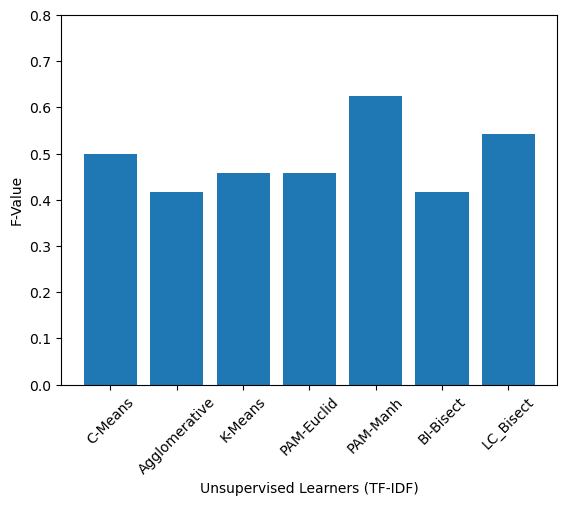

In [30]:
data = [fcm_best, agg_best, km_best, pam_best, pam_manh_best, bi_bisect_best, lc_bisect_best]
labels = ['C-Means', 'Agglomerative', 'K-Means','PAM-Euclid','PAM-Manh', 'BI-Bisect', 'LC_Bisect']
plt.xticks(range(len(data)), labels)
plt.ylim([0, 0.8])
plt.xlabel('Unsupervised Learners (TF-IDF)')
plt.ylabel('F-Value')
plt.bar(range(len(data)), data) 
plt.xticks(rotation=45)
plt.show()